In [3]:
pip install matplotlib

  Using cached matplotlib-3.9.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.2.1-cp312-cp312-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.51.0-cp312-cp312-win_amd64.whl.metadata (162 kB)
  Using cached kiwisolver-1.4.5-cp312-cp312-win_amd64.whl.metadata (6.5 kB)
  Using cached pillow-10.3.0-cp312-cp312-win_amd64.whl.metadata (9.4 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
Using cached matplotlib-3.9.0-cp312-cp312-win_amd64.whl (8.0 MB)
Using cached contourpy-1.2.1-cp312-cp312-win_amd64.whl (189 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.51.0-cp312-cp312-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.5-cp312-cp312-win_amd64.whl (56 kB)
Using cached pillow-10.3.0-cp312-cp312-win_amd64.whl (2.5 MB)
Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scipy

In [25]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp
import random

In [32]:
# Parse the interactome file
def parse_interactome(file_path):
    interactome_data = []
    with open(file_path, 'r') as file:
        # Skip the header line
        next(file)
        for line in file:
            line_data = line.strip().split('\t')
            tail, head, edge_weight, edge_type = line_data
            # Convert edge weight to float
            edge_weight = float(edge_weight)
            interactome_data.append((tail, head, edge_weight, edge_type))
    return interactome_data

In [33]:
# Graph Construction
def construct_graph(interactome_data):
    G = nx.DiGraph()
    for tail, head, edge_weight, _ in interactome_data:
        G.add_edge(tail, head, weight=edge_weight)
    return G

In [34]:
# Basic Analysis
def analyze_graph(G):
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    avg_degree = sum(dict(G.degree()).values()) / num_nodes
    print("Number of nodes:", num_nodes)
    print("Number of edges:", num_edges)
    print("Average degree:", avg_degree)

In [106]:
def get_unique_nodes(G):
    return list(G.nodes())

In [136]:
def get_most_connected_nodes(G, n):
    return sorted(dict(G.degree()).items(), key=lambda x: x[1], reverse=True)[:n]

In [128]:
def visualize_graph(G, limit=100):
    # Get a subgraph of the first 100 nodes
    subgraph_nodes = get_unique_nodes(G)[:limit]
    subgraph = G.subgraph(subgraph_nodes)
    
    # Draw the subgraph with improved aesthetics
    pos = nx.spring_layout(subgraph, k=0.15)  # Adjust layout algorithm and parameters
    nx.draw(subgraph, pos, with_labels=True, node_size=100, node_color='skyblue', edge_color='gray', width=0.5, font_size=5)
    
    # Customize plot aesthetics
    plt.title("Visualization of Subgraph")
    plt.axis('off')  # Turn off axis
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


In [138]:
def visualize_graph_edge(G, node_limit=100, edge_threshold=100):
    # Get a subgraph with a limited number of nodes
    subgraph_nodes = [node for node, degree in G.degree() if degree > 0][:node_limit]
    subgraph = G.subgraph(subgraph_nodes)
    
    # Get edges with confidence above the threshold
    edges_above_threshold = [(u, v) for u, v, d in subgraph.edges(data=True) if d['weight'] > edge_threshold]
    
    # Draw the subgraph with improved aesthetics
    pos = nx.spring_layout(subgraph, k=0.15)  # Adjust layout algorithm and parameters
    nx.draw(subgraph, pos, with_labels=True, node_size=100, node_color='skyblue', edge_color='gray', width=0.5, font_size=5)
    
    # Draw edges above the threshold
    nx.draw_networkx_edges(subgraph, pos, edgelist=edges_above_threshold, edge_color='red', width=1.5)

    # Customize plot aesthetics
    plt.title("Visualization of Subgraph with Edge Threshold")
    plt.axis('off')  # Turn off axis
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


In [125]:
# Implement a function to find acyclic shortest paths between two proteins
def find_acyclic_shortest_paths(graph, source, target):
    acyclic_shortest_paths = []
    for path in nx.all_shortest_paths(graph, source=source, target=target):
        if len(path) == len(set(path)):
            acyclic_shortest_paths.append(path)
    return acyclic_shortest_paths

In [36]:
#Generate a text file listing the acyclic shortest paths between two proteins
def write_shortest_paths_to_file(paths, file_path, graph):
    with open(file_path, 'w') as file:
        for i, path in enumerate(paths, start=1):
            total_score = sum(graph[path[j]][path[j+1]]['weight'] for j in range(len(path)-1))
            file.write(f"Path {i}: {' -> '.join(path)}\n")
            file.write(f"Total Path Score: {total_score}\n")
            for j in range(len(path)-1):
                weight = graph[path[j]][path[j+1]]['weight']
                file.write(f"Interaction Weight ({path[j]} -> {path[j+1]}): {weight}\n")
            file.write('\n')


In [73]:
def visualize_shortest_paths_only(shortest_paths, source, target):
    plt.figure(figsize=(10, 8))
    pos = None  # No need to compute layout for only paths
    
    # Create an empty graph
    shortest_path_graph = nx.DiGraph()
    
    # Add nodes and edges from the shortest paths to the graph
    for path in shortest_paths:
        for i in range(len(path) - 1):
            shortest_path_graph.add_edge(path[i], path[i+1])
    
    # Define node colors
    node_colors = ['lightgreen' if node == source else 'lightcoral' if node == target else 'lightblue' for node in shortest_path_graph.nodes()]
    
    # Draw the shortest paths with custom node colors
    nx.draw_networkx(shortest_path_graph, pos, with_labels=True, node_size=2000, node_color=node_colors, font_size=10, font_weight='bold', edge_color='red', width=2, alpha=0.5)
    
    plt.title("Shortest Paths between Source(green) and Target(lightcoral) Proteins")
    plt.axis('off')
    plt.show()


Number of nodes: 17168
Number of edges: 612516
Average degree: 71.35554520037279


C:\Users\Hassan\AppData\Local\Temp\ipykernel_2352\2077039014.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


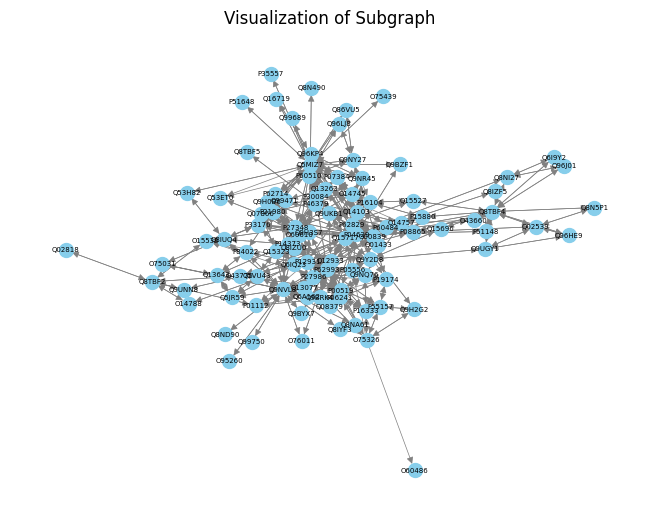

C:\Users\Hassan\AppData\Local\Temp\ipykernel_2352\1709660364.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


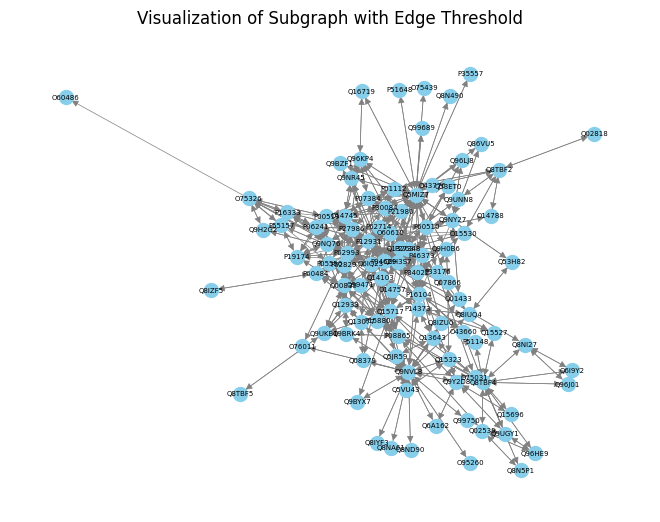

In [139]:
# Main code
file_path = "PathLinker_2018_human-ppi-weighted-cap0_75.txt"
interactome_data = parse_interactome(file_path)
graph = construct_graph(interactome_data)
analyze_graph(graph)
visualize_graph(graph, limit=100)
visualize_graph_edge(graph, node_limit=100, edge_threshold=100)

In [ ]:
def get

Number of acyclic shortest paths: 6


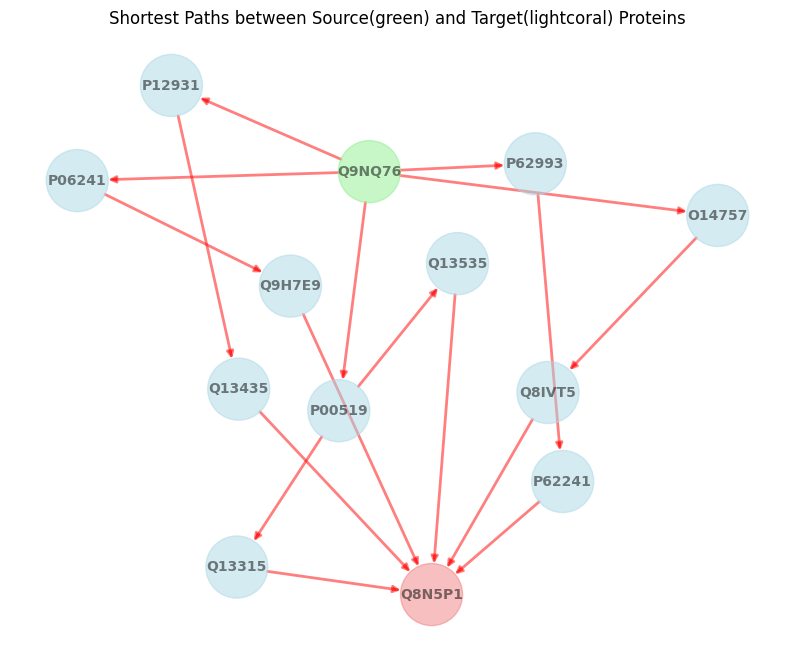

In [113]:

source = "Q9NQ76"
target = "Q8N5P1"
acyclic_shortest_paths = find_acyclic_shortest_paths(graph, source, target)
print("Number of acyclic shortest paths:", len(acyclic_shortest_paths))
write_shortest_paths_to_file(acyclic_shortest_paths, "acyclic_shortest_paths.txt", graph)
visualize_shortest_paths_only(acyclic_shortest_paths, source, target)